In [1]:
import sys

from scipy.stats import cosine

sys.version

'3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]'

In [2]:
data = {}

path_to_data = 'all_time-series\\ts_cut'

import os
import numpy as np
import re

parser_regex = r'(ihb|china|rmet)_(open|close)_strategy-(\d)_(GSR|noGSR).npy'
extractor = re.compile(parser_regex)

for root, dirs, files in os.walk(path_to_data):
    for file in files:
        source = root.split(os.sep)[3]
        if source in ['ihb', 'china', 'rmet']:
            atlas = root.split(os.sep)[2]
            match_obj = extractor.match(file)
            if match_obj.groups()[2] in ['1', '2', '3', '4', '5', '6']:
                print((atlas, ) + match_obj.groups())
                data[(atlas, ) + match_obj.groups()] = np.load(os.path.join(root, file))

('AAL', 'china', 'close', '1', 'GSR')
('AAL', 'china', 'close', '1', 'noGSR')
('AAL', 'china', 'close', '2', 'GSR')
('AAL', 'china', 'close', '2', 'noGSR')
('AAL', 'china', 'close', '3', 'GSR')
('AAL', 'china', 'close', '3', 'noGSR')
('AAL', 'china', 'close', '4', 'GSR')
('AAL', 'china', 'close', '4', 'noGSR')
('AAL', 'china', 'close', '5', 'GSR')
('AAL', 'china', 'close', '5', 'noGSR')
('AAL', 'china', 'close', '6', 'GSR')
('AAL', 'china', 'close', '6', 'noGSR')
('AAL', 'china', 'open', '1', 'GSR')
('AAL', 'china', 'open', '1', 'noGSR')
('AAL', 'china', 'open', '2', 'GSR')
('AAL', 'china', 'open', '2', 'noGSR')
('AAL', 'china', 'open', '3', 'GSR')
('AAL', 'china', 'open', '3', 'noGSR')
('AAL', 'china', 'open', '4', 'GSR')
('AAL', 'china', 'open', '4', 'noGSR')
('AAL', 'china', 'open', '5', 'GSR')
('AAL', 'china', 'open', '5', 'noGSR')
('AAL', 'china', 'open', '6', 'GSR')
('AAL', 'china', 'open', '6', 'noGSR')
('AAL', 'ihb', 'close', '1', 'GSR')
('AAL', 'ihb', 'close', '1', 'noGSR')
('

In [3]:
import pandas as pd

df = pd.DataFrame(list([val] for val in data.values()), index=pd.MultiIndex.from_tuples(data.keys(), names=['atlas', 'dataset', 'class', 'strategy', 'GSR']))
df.sort_index(inplace=True);

In [4]:
print(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item().shape,
df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item().shape,
df.loc['HCPex', 'rmet', 'open', '2',   'GSR'].item().shape,
df.loc['Schaefer200', 'rmet', 'open', '2',   'GSR'].item().shape)

(63, 120, 116) (63, 120, 246) (63, 120, 419) (63, 120, 200)


In [5]:
df.index

MultiIndex([(        'AAL', 'china', 'close', '1',   'GSR'),
            (        'AAL', 'china', 'close', '1', 'noGSR'),
            (        'AAL', 'china', 'close', '2',   'GSR'),
            (        'AAL', 'china', 'close', '2', 'noGSR'),
            (        'AAL', 'china', 'close', '3',   'GSR'),
            (        'AAL', 'china', 'close', '3', 'noGSR'),
            (        'AAL', 'china', 'close', '4',   'GSR'),
            (        'AAL', 'china', 'close', '4', 'noGSR'),
            (        'AAL', 'china', 'close', '5',   'GSR'),
            (        'AAL', 'china', 'close', '5', 'noGSR'),
            ...
            ('Schaefer200',  'rmet',  'open', '2',   'GSR'),
            ('Schaefer200',  'rmet',  'open', '2', 'noGSR'),
            ('Schaefer200',  'rmet',  'open', '3',   'GSR'),
            ('Schaefer200',  'rmet',  'open', '3', 'noGSR'),
            ('Schaefer200',  'rmet',  'open', '4',   'GSR'),
            ('Schaefer200',  'rmet',  'open', '4', 'noGSR'),
        

In [6]:
df.shape

(288, 1)

In [7]:
df.iloc[0].item().shape

(95, 240, 116)

In [8]:
connectome_data = {}

from nilearn.connectome import ConnectivityMeasure

def get_connectome(timeseries: np.ndarray,
                   conn_type: str = 'corr') -> np.ndarray:

    if conn_type == 'corr':
        conn = ConnectivityMeasure(kind='correlation', standardize=False).fit_transform(timeseries)
        conn[conn == 1] = 0.999999

        for i in conn:
            np.fill_diagonal(i, 0)

        conn = np.arctanh(conn)

    else:
        raise NotImplementedError

    return conn

for key in data:
    connectome_data[key] = get_connectome(list(data[key]))

In [9]:
SIZE = 10

In [10]:
import pandas as pd

df_connectome = pd.DataFrame(list([val] for val in connectome_data.values()), index=pd.MultiIndex.from_tuples(data.keys(), names=['atlas', 'dataset', 'class', 'strategy', 'GSR']))

In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_procrustes_similarity_measure(left, right, params):
    if right.shape[-1] > left.shape[-1]:
        left, right = right, left
    X = left - left.mean(axis=1, keepdims=True)
    Y = right - right.mean(axis=1, keepdims=True)

    X = X / np.linalg.norm(X, axis=(-2, -1), keepdims=True)
    Y = Y / np.linalg.norm(Y, axis=(-2, -1), keepdims=True)

    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    Y_estimation = (X @ Vh.transpose(0, 2, 1) / S[..., None, :] @ U.transpose(0, 2, 1))[:, None, ...] @ Y[None, :, ...] # Y=XA

    y_error = ((Y_estimation - Y[None, :, ...])**2).sum((-2, -1))
    sim = - y_error
    return sim

import scipy

SIZE = 116

def get_correlation_measure(left, right, params):
    l_ = []
    r_ = []
    left_ = []
    right_ = []
    for i in range(len(left)):
        dists = scipy.spatial.distance.cdist(left[i][:,:116].T, right[i][:,:116].T, metric=params['metric'])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        # print(row_ind, col_ind)
        nleft = [[left[i][ii][row_ind[jj]] for jj in range(116)] for ii in range(120)]
        nright = [[right[i][ii][col_ind[jj]] for jj in range(116)] for ii in range(120)]
        left_.append(nleft)
        right_.append(nright)
    
    left_ = np.array(left_)
    right_ = np.array(right_)
    for i in range(63):
        l_.append(left_[i].flatten()[:SIZE])
        r_.append(right_[i].flatten()[:SIZE])
    l_ = np.array(l_)
    r_ = np.array(r_)
    print(l_.shape, r_.shape)
    return np.corrcoef(l_, r_)

def best_assignment_score(left, right, params):
    sim = np.full((len(left), len(right)), -np.inf)
    for i in range(len(left)):
        for j in range(len(right)):
            dists = scipy.spatial.distance.cdist(left[i][:,:SIZE].T, right[j][:,:SIZE].T, metric=params['metric'])
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
            sim[i, j] = - dists[row_ind, col_ind].sum()
    return sim

(63, 116) (63, 116)
(126, 126)
(63, 116) (63, 116)


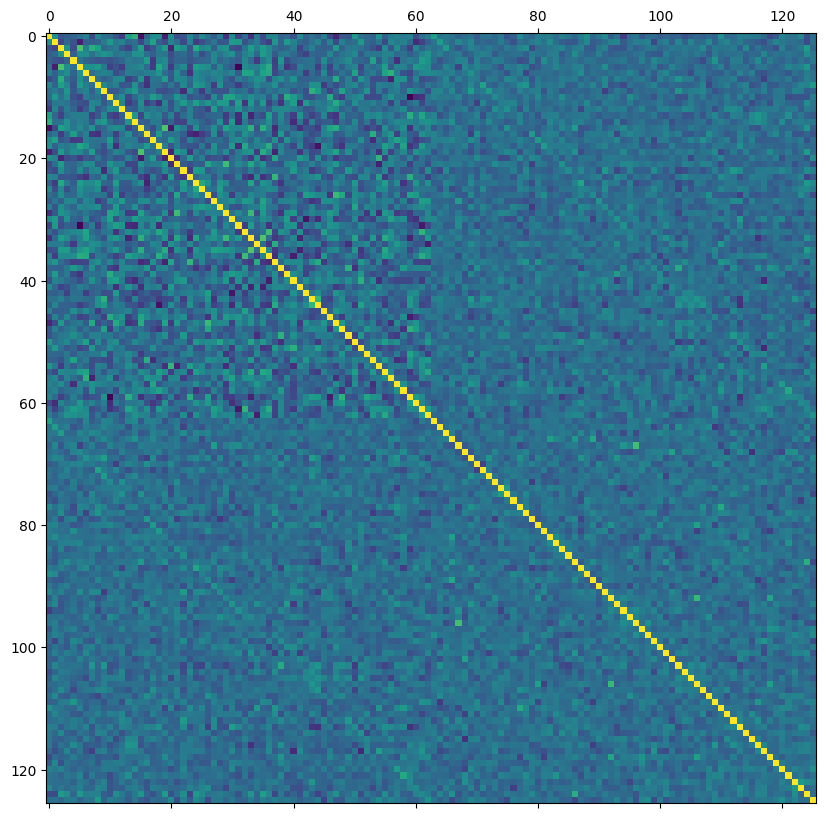

In [13]:
a = get_correlation_measure(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
print(a.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(get_correlation_measure(df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'}))

(63, 116) (63, 116)
(126, 126)
(63, 116) (63, 116)


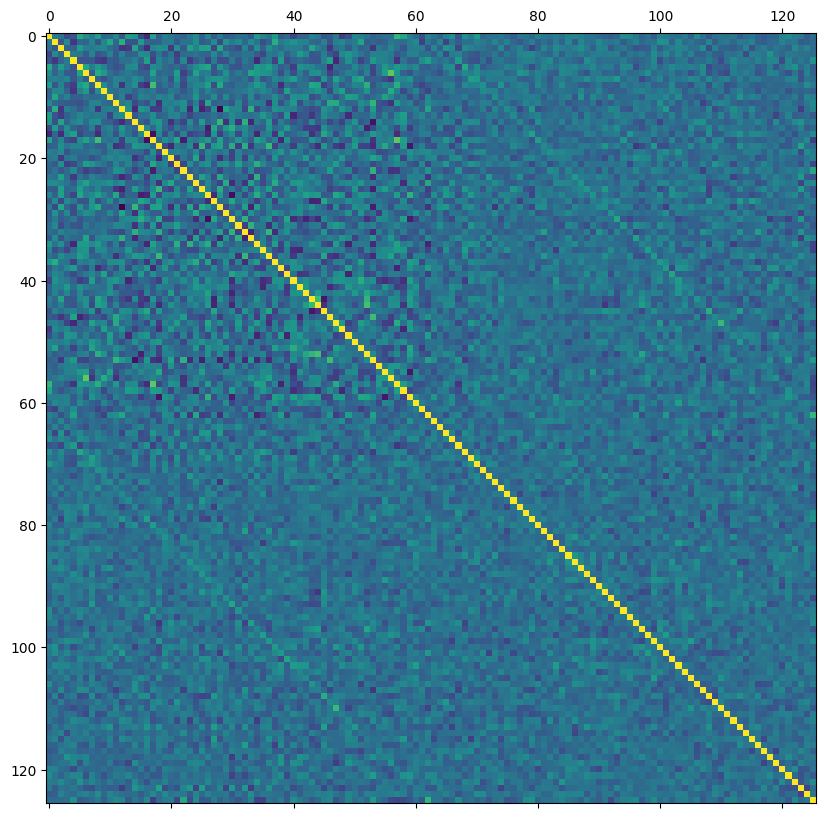

In [14]:
a = get_correlation_measure(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
print(a.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(get_correlation_measure(df.loc['Schaefer200', 'rmet', 'open', '2',   'GSR'].item(), df.loc['HCPex', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'}))

(63, 116) (63, 116)
(126, 126)
(63, 116) (63, 116)


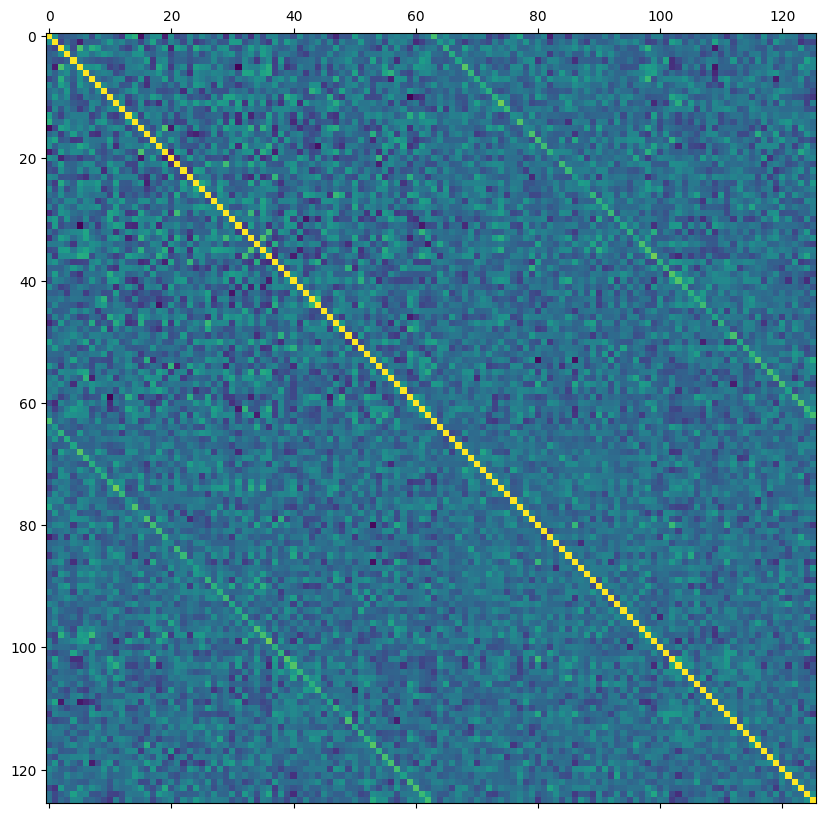

In [15]:
a = get_correlation_measure(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
print(a.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(get_correlation_measure(df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), {'metric': 'cosine'}))

(63, 116) (63, 116)
(126, 126)
(63, 116) (63, 116)


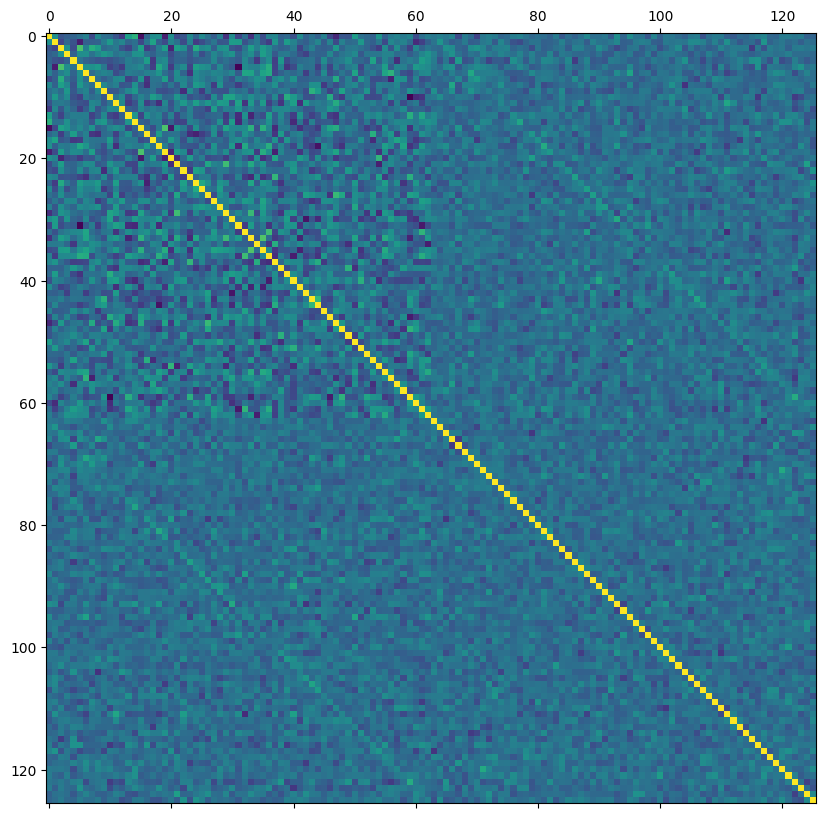

In [16]:
a = get_correlation_measure(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
print(a.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(get_correlation_measure(df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(), df.loc['Brainnetome', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'}))

In [17]:
def get_procrustes_similarity_measure(left, right, params):
    if right.shape[-1] > left.shape[-1]:
        left, right = right, left
    X = left - left.mean(axis=1, keepdims=True)
    Y = right - right.mean(axis=1, keepdims=True)

    X = X / np.linalg.norm(X, axis=(-2, -1), keepdims=True)
    Y = Y / np.linalg.norm(Y, axis=(-2, -1), keepdims=True)

    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    Y_estimation = (X @ Vh.transpose(0, 2, 1) / S[..., None, :] @ U.transpose(0, 2, 1))[:, None, ...] @ Y[None, :, ...] # Y=XA

    y_error = ((Y_estimation - Y[None, :, ...])**2).sum((-2, -1))
    sim = - y_error
    return sim

import scipy

SIZE = 116

def get_correlation_measure_right(left, right, params):
    res = np.full((len(left), len(right)), -np.inf)
    for i in range(len(left)):
        for j in range(len(right)):
            dists = scipy.spatial.distance.cdist(left[i][:,:116].T, right[j][:,:116].T, metric=params['metric'])
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
            # nleft = [[left[i][ii][row_ind[jj]] for jj in range(116)] for ii in range(120)]
            # nright = [[right[j][ii][col_ind[jj]] for jj in range(116)] for ii in range(120)]

            nleft = [[left[i][ii][jj] for jj in range(116)] for ii in range(120)]
            nright = [[right[j][ii][jj] for jj in range(116)] for ii in range(120)]

            left_ = np.array(nleft).flatten()[:SIZE]
            right_ = np.array(nright).flatten()[:SIZE]

            res[i, j] = np.corrcoef(left_, right_)[0, 1]
            res[j, i] = np.corrcoef(left_, right_)[1, 0]
    return res

def best_assignment_score(left, right, params):
    sim = np.full((len(left), len(right)), -np.inf)
    for i in range(len(left)):
        for j in range(len(right)):
            dists = scipy.spatial.distance.cdist(left[i][:,:SIZE].T, right[j][:,:SIZE].T, metric=params['metric'])
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
            sim[i, j] = - dists[row_ind, col_ind].sum()
    return sim

(63, 116) (63, 116)
(126, 126)


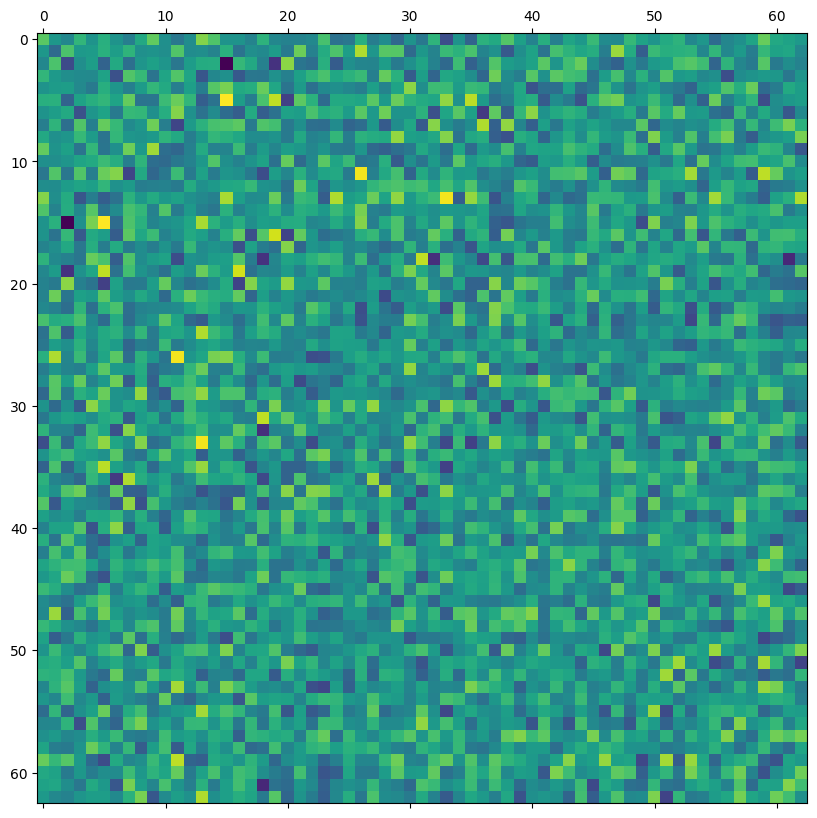

In [18]:
a = get_correlation_measure(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
print(a.shape)
fig, ax = plt.subplots(figsize=(10,10))

ax.matshow(get_correlation_measure_right(df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(), df.loc['Brainnetome', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'}))

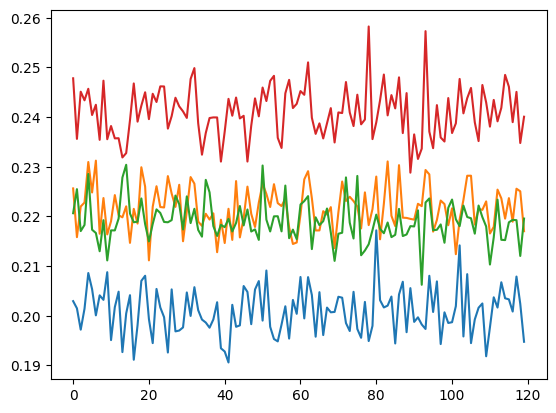

In [19]:
def best_assignment_score2(left, right, params):
    part = [0 for i in range(120)]
    sim = np.full((len(left), len(right)), -np.inf)
    for i in range(len(left)):
        dists = scipy.spatial.distance.cdist(left[i][:,:SIZE].T, right[i][:,:SIZE].T, metric=params['metric'])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        nleft = [[left[i][ii][row_ind[jj]] for jj in range(SIZE)] for ii in range(120)]
        nright = [[right[i][ii][col_ind[jj]] for jj in range(SIZE)] for ii in range(120)]
        for j in range(120):
            part[j] += scipy.spatial.distance.cosine(nleft[j], nright[j])
    part = [part[i] / len(left) for i in range(120)]
    return part

AAL_sort =  best_assignment_score2(
        np.abs(np.fft.fft(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item())),
        np.abs(np.fft.fft(df.loc['AAL',  'rmet',  'close', '2',   'GSR'].item())),
        {'metric': 'cosine'})
plt.plot(AAL_sort)
AAL_sort = [(AAL_sort[i], i) for i in range(len(AAL_sort))]
AAL_sort.sort()
Brainnetome_sort =  best_assignment_score2(
        np.abs(np.fft.fft(df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item())),
        np.abs(np.fft.fft(df.loc['Brainnetome',  'rmet',  'close', '2',   'GSR'].item())),
        {'metric': 'cosine'})
plt.plot(Brainnetome_sort)
Brainnetome_sort = [(Brainnetome_sort[i], i) for i in range(len(Brainnetome_sort))]
Brainnetome_sort.sort()
HCPex_sort =  best_assignment_score2(
        np.abs(np.fft.fft(df.loc['HCPex', 'rmet', 'open', '2',   'GSR'].item())),
        np.abs(np.fft.fft(df.loc['HCPex',  'rmet',  'close', '2',   'GSR'].item())),
        {'metric': 'cosine'})
plt.plot(HCPex_sort)
HCPex_sort = [(HCPex_sort[i], i) for i in range(len(HCPex_sort))]
HCPex_sort.sort()
Schaefer200_sort =  best_assignment_score2(
        np.abs(np.fft.fft(df.loc['Schaefer200', 'rmet', 'open', '2',   'GSR'].item())),
        np.abs(np.fft.fft(df.loc['Schaefer200',  'rmet',  'close', '2',   'GSR'].item())),
        {'metric': 'cosine'})
plt.plot(Schaefer200_sort)
Schaefer200_sort = [(Schaefer200_sort[i], i) for i in range(len(Schaefer200_sort))]
Schaefer200_sort.sort()
plt.show()

In [20]:
AAL_pos = [AAL_sort[i][1] for i in range(120)]
Brainnetome_pos = [Brainnetome_sort[i][1] for i in range(120)]
HCPex_pos = [HCPex_sort[i][1] for i in range(120)]
Schaefer200_pos = [Schaefer200_sort[i][1] for i in range(120)]
print(AAL_pos)
print(Brainnetome_pos)
print(HCPex_pos)
print(Schaefer200_pos)

[41, 16, 109, 25, 13, 40, 39, 97, 85, 105, 21, 119, 54, 78, 10, 53, 57, 76, 64, 103, 66, 88, 27, 73, 28, 2, 93, 75, 36, 29, 110, 43, 52, 79, 44, 17, 55, 92, 47, 72, 99, 35, 100, 90, 50, 34, 37, 106, 20, 61, 91, 24, 31, 6, 59, 14, 98, 68, 95, 69, 116, 33, 3, 1, 107, 67, 112, 82, 23, 11, 56, 101, 83, 42, 118, 108, 38, 77, 0, 81, 58, 8, 115, 114, 71, 111, 70, 84, 7, 15, 63, 86, 30, 65, 46, 74, 12, 48, 26, 5, 22, 89, 32, 45, 113, 87, 96, 49, 18, 62, 60, 117, 94, 19, 104, 4, 9, 51, 102, 80]
[20, 101, 38, 69, 58, 40, 15, 59, 29, 42, 81, 44, 1, 9, 7, 110, 95, 119, 64, 65, 76, 57, 48, 111, 85, 34, 99, 78, 106, 17, 116, 33, 10, 96, 39, 90, 36, 102, 89, 114, 45, 88, 87, 13, 84, 12, 67, 60, 47, 35, 37, 70, 66, 30, 108, 79, 107, 16, 41, 100, 24, 68, 52, 23, 27, 21, 75, 2, 14, 92, 55, 98, 82, 91, 54, 49, 3, 109, 74, 72, 97, 103, 56, 113, 63, 115, 8, 73, 11, 51, 26, 5, 77, 118, 112, 117, 0, 19, 46, 22, 28, 53, 32, 50, 71, 43, 61, 31, 80, 25, 104, 105, 94, 62, 93, 18, 86, 4, 83, 6]
[92, 110, 69, 9, 1

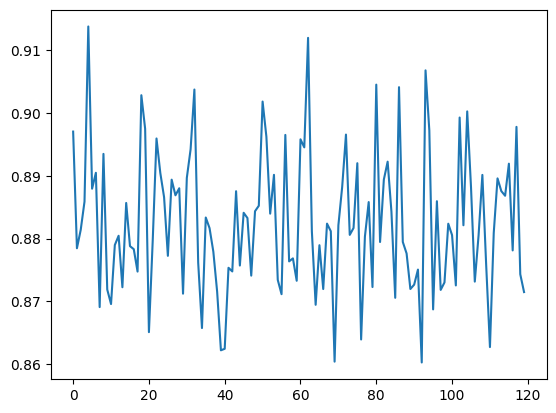

In [21]:
all_sort = [0 for i in range(120)]
for x, i in AAL_sort:
    all_sort[i] += x
for x, i in Brainnetome_sort:
    all_sort[i] += x
for x, i in HCPex_sort:
    all_sort[i] += x
for x, i in Schaefer200_sort:
    all_sort[i] += x
plt.plot(all_sort)
plt.show()

In [22]:
all_sort = [(all_sort[i], i) for i in range(120)]
all_sort.sort()
for x, i in all_sort:
    print(i, x)

92 0.8602276130481714
69 0.8603603894020656
39 0.8621708395990102
40 0.8624095504002574
110 0.8626846179402672
76 0.863896865208601
20 0.8650654815702749
34 0.8657198949358814
95 0.8686935588704701
7 0.8690622685819684
64 0.8694274066558498
10 0.8695500670027043
85 0.8705437821744465
55 0.8711238806473606
29 0.8712027820248706
119 0.8714566056592787
38 0.8715352748641527
97 0.8718024178356284
9 0.8718599625276038
66 0.8719432810961635
89 0.8719475384910599
13 0.8722286826577985
79 0.8722615274164471
101 0.8725164982568773
90 0.872641632716274
98 0.8729914420461278
106 0.8731259181139646
59 0.873262943977465
54 0.8734034445062078
47 0.8740806264105104
118 0.8743052909709802
17 0.8747259549757559
42 0.8747500435092306
91 0.87504228884285
41 0.8753320407772353
44 0.8756898334540459
109 0.875827966863638
33 0.8761629884354906
57 0.8763538877942103
58 0.8768326734644792
25 0.8772385268745893
88 0.8776185122601492
37 0.8778930153203909
116 0.8781034594146776
16 0.8782985738856088
1 0.8784484

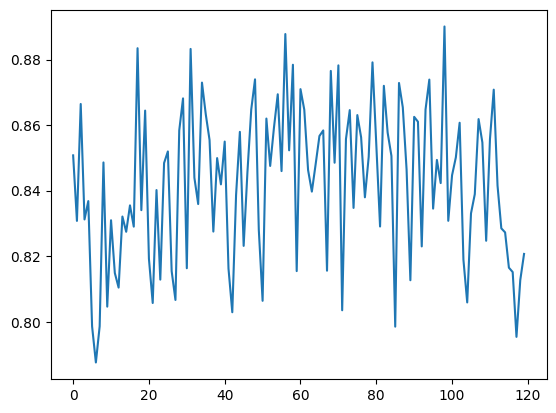

In [23]:
plt.plot(
    best_assignment_score2(
        df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(),
        df.loc['Brainnetome',  'rmet',  'close', '2',   'GSR'].item(),
        {'metric': 'euclid'})
    )

In [24]:
K = 10

(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120) (116, 120)
(116, 120) (116, 120) (116, 120)

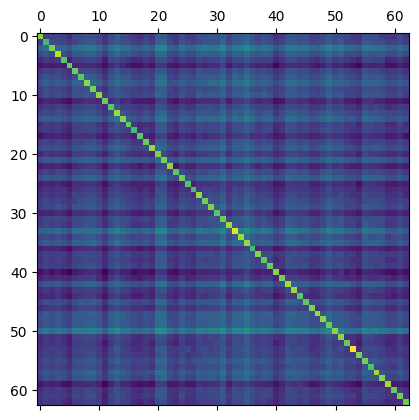

In [25]:
plt.matshow(
    best_assignment_score(
        df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item(),
        df.loc['AAL',  'rmet',  'open', '2',   'GSR'].item(),
        {'metric': 'euclid'})
    )

matches = {}
for i in range(len(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item())):
    matches[i] = [df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item()[i][:,:SIZE].T, df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item()[i][:,:SIZE].T, df.loc['HCPex', 'rmet', 'open', '2',   'GSR'].item()[i][:,:SIZE].T, df.loc['Schaefer200', 'rmet', 'open', '2',   'GSR'].item()[i][:,:SIZE].T]
    print(matches[i][0].shape, matches[i][1].shape, matches[i][2].shape, matches[i][3].shape)

N = 63 * 6
data_pairs = []
for i in range(len(matches)):
    for j in range(len(matches[i])):
        for k in range(j + 1, len(matches[i])):
            data_pairs.append((matches[i][j], matches[i][k]))

import random

def bestest_assignment_score(left, right, params):
    sim = np.full((len(left)), np.inf)
    for i in range(len(left)):
        dists = scipy.spatial.distance.cdist(left[i], right[i], metric=params['metric'])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        sim[i] = dists[row_ind, col_ind].sum()
    return sim

for i in range(N * K):
    j, k = 0, 0
    while j == k:
        j, k = random.randint(0, len(matches) - 1), random.randint(0, len(matches) - 1)
    x, y = random.randint(0, len(matches[j]) - 1), random.randint(0, len(matches[k]) - 1)
    data_pairs.append((matches[j][x], matches[k][y]))

left = []
right = []
for x, y in data_pairs:
    left.append(x)
    right.append(y)

[50.74375351 60.43751406 50.70707002 ... 92.40810211 93.87687075
 94.36110779]


(array([1.200e+01, 6.500e+01, 1.390e+02, 9.800e+01, 6.200e+01, 2.000e+00,
        0.000e+00, 0.000e+00, 5.200e+01, 3.728e+03]),
 array([38.0604305 , 43.96293195, 49.86543341, 55.76793486, 61.67043632,
        67.57293777, 73.47543923, 79.37794068, 85.28044214, 91.18294359,
        97.08544505]),
 <BarContainer object of 10 artists>)

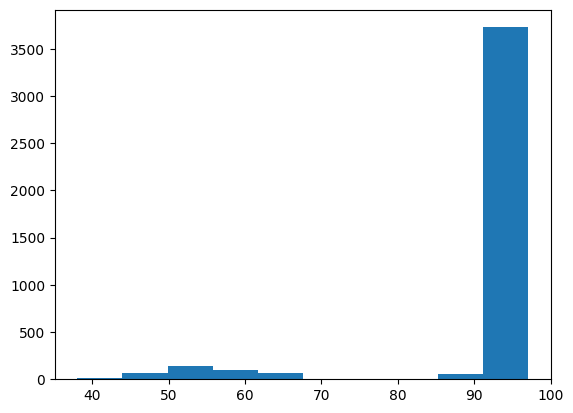

In [26]:
bestest = bestest_assignment_score(left, right, {'metric': 'cosine'})
print(bestest)
plt.hist(bestest)

857.3271815053015 1222.9772114043885
852.4024799495287 1677.8846100644962
[1118.46096419 1098.60993542 1131.92358214 ... 1397.23121394 1489.51068805
 1439.84152382]


(array([  14.,   52.,  115.,  264.,  214.,  480.,  890., 1077.,  890.,
         162.]),
 array([ 852.40247995,  934.95069296, 1017.49890597, 1100.04711898,
        1182.595332  , 1265.14354501, 1347.69175802, 1430.23997103,
        1512.78818404, 1595.33639705, 1677.88461006]),
 <BarContainer object of 10 artists>)

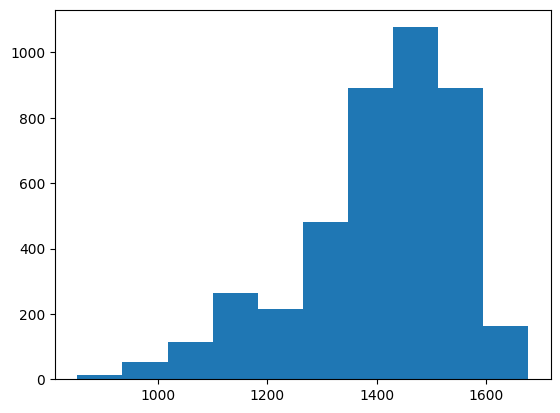

In [27]:
bestest = bestest_assignment_score(left, right, {'metric': 'euclid'})
print(min(bestest[:63*6]), max(bestest[:63*6]))
print(min(bestest[63*6:]), max(bestest[63*6:]))
print(bestest)
plt.hist(bestest)

In [28]:
def get_correlation_measure_brain_parts(left, right, params):
    res = np.full((len(left), (len(left[0][0]) + len(right[0][0])) ** 2), -np.inf)
    for chel in range(len(left)):
        # dists = scipy.spatial.distance.cdist(left[chel].T, right[chel].T, metric=params['metric'])
        # row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        # nleft = [[left[i][ii][row_ind[jj]] for jj in range(116)] for ii in range(120)]
        # nright = [[right[j][ii][col_ind[jj]] for jj in range(116)] for ii in range(120)]
        # print(left[chel].T.shape)
        res[chel] = np.corrcoef(left[chel].T, right[chel].T).flatten()
    return res

In [29]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.matshow(get_correlation_measure_brain_parts(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), {'metric': 'cosine'})[0])
# print(get_correlation_measure_brain_parts(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'}).shape)

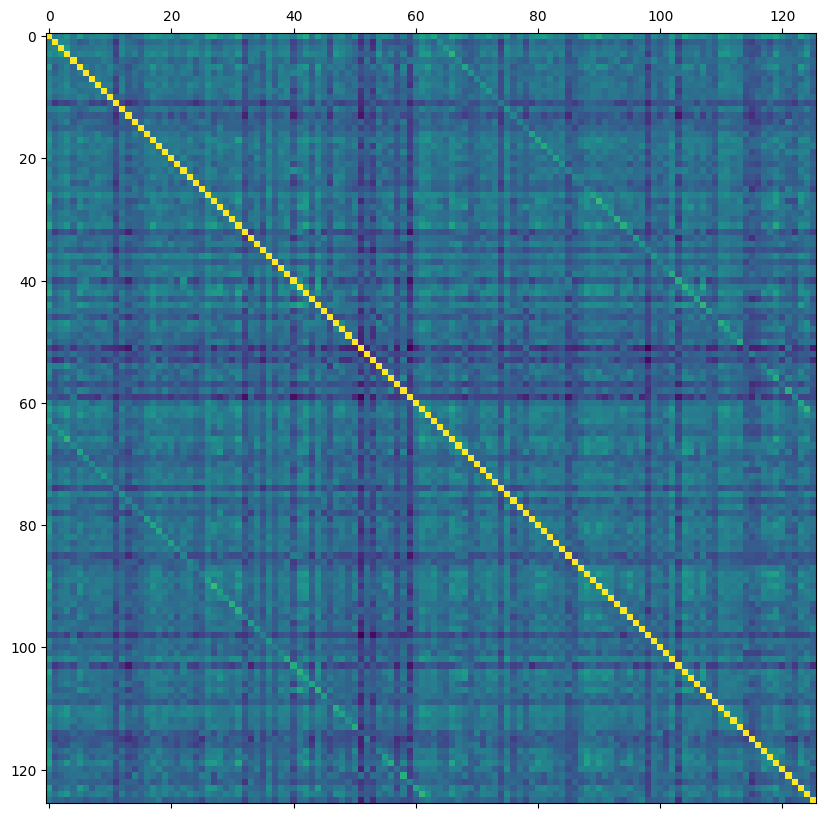

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
table = np.corrcoef(
    get_correlation_measure_brain_parts(df.loc['AAL', 'rmet', 'open', '3',   'GSR'].item(), df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), {'metric': 'cosine'}),
    get_correlation_measure_brain_parts(df.loc['AAL', 'rmet', 'close', '3',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
)
ax.matshow(table)

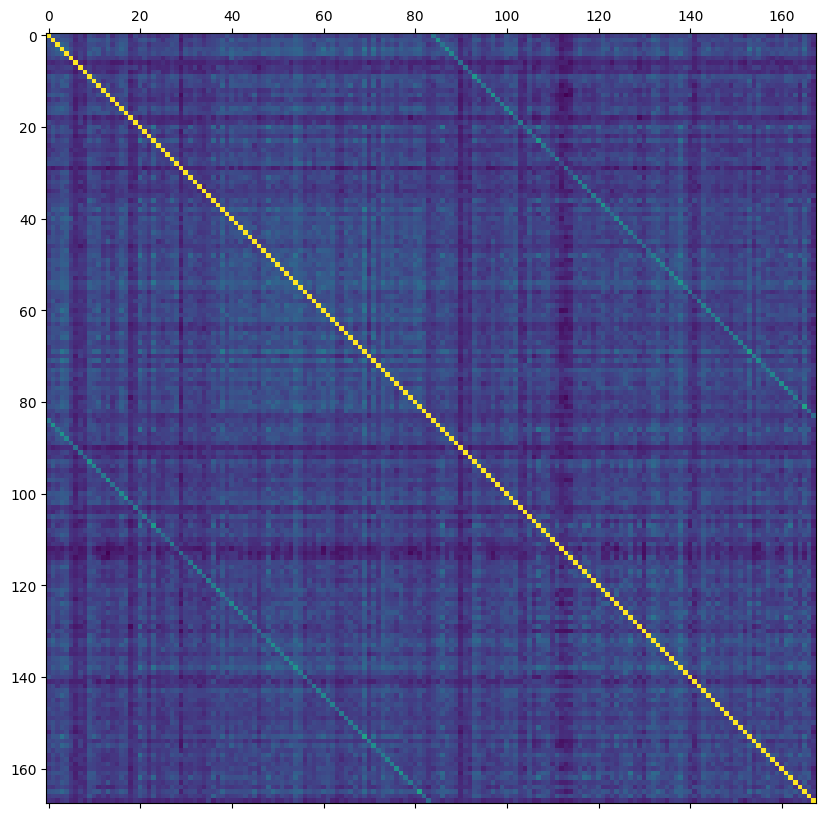

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
table = np.corrcoef(
    get_correlation_measure_brain_parts(df.loc['HCPex', 'ihb', 'open', '2',   'GSR'].item(), df.loc['Brainnetome', 'ihb', 'open', '2',   'GSR'].item(), {'metric': 'cosine'}),
    get_correlation_measure_brain_parts(df.loc['HCPex', 'ihb', 'close', '2',   'GSR'].item(), df.loc['Brainnetome', 'ihb', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
)
ax.matshow(table)

In [32]:
def get_correlation_measure_brain_parts_fft(left, right, params):
    res = np.full((len(left), 232 * 232), -np.inf)
    for chel in range(len(left)):
        dists = scipy.spatial.distance.cdist(left[chel].T[:116, :], right[chel].T[:116, :], metric=params['metric'])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        # nleft = [[left[i][ii][row_ind[jj]] for jj in range(116)] for ii in range(120)]
        # nright = [[right[j][ii][col_ind[jj]] for jj in range(116)] for ii in range(120)]
        # print(left[chel].T.shape)
        res[chel] = np.corrcoef(np.abs(np.fft.fft(left[chel].T)), np.abs(np.fft.fft(right[chel].T))).flatten()
    return res

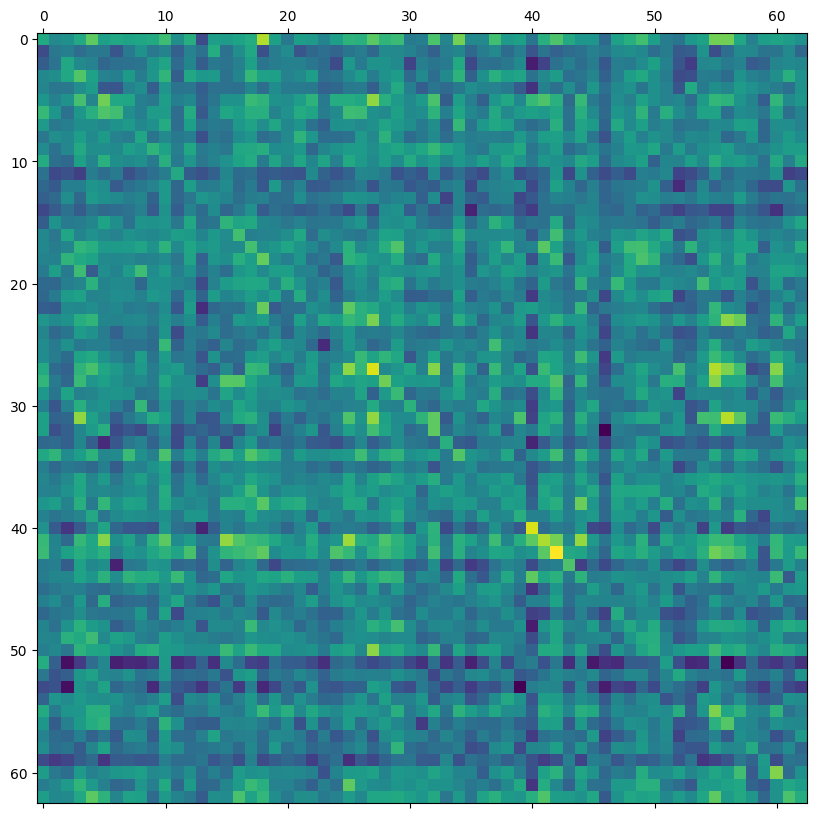

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
table = np.corrcoef(
    get_correlation_measure_brain_parts_fft(df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'open', '2',   'GSR'].item(), {'metric': 'cosine'}),
    get_correlation_measure_brain_parts_fft(df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), df.loc['AAL', 'rmet', 'close', '2',   'GSR'].item(), {'metric': 'cosine'})
)
ax.matshow(table[0:63, 63:])
plt.savefig("fft_brain_parts_correlation.png")

In [34]:
standard = np.full((63, 63), 0)
for i in range(63):
    standard[i, i] = 1
print(standard)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [35]:
def get_correlation_measure_brain_parts_by_len(left, right, params, l):
    res = np.full((len(left), 116 * 116), -np.inf)
    for chel in range(len(left)):
        # dists = scipy.spatial.distance.cdist(left[chel].T[:116, :], right[chel].T[:116, :], metric=params['metric'])
        # row_ind, col_ind = scipy.optimize.linear_sum_assignment(dists)
        current = np.full((116 * 116), 0.0)
        for j in range(0, 120 - l):
            current += (np.corrcoef(left[chel].T[:, j:j+l], right[chel].T[:, j:j+l])[:116, 116:]).flatten()
        res[chel] = current / (120 - l)
    return res

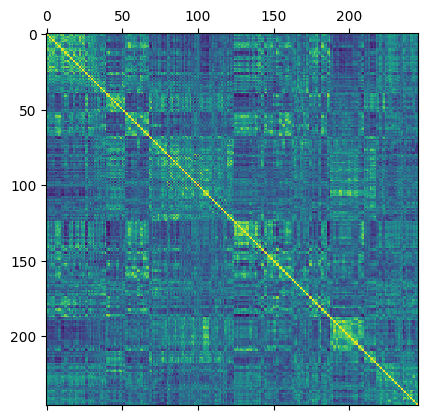

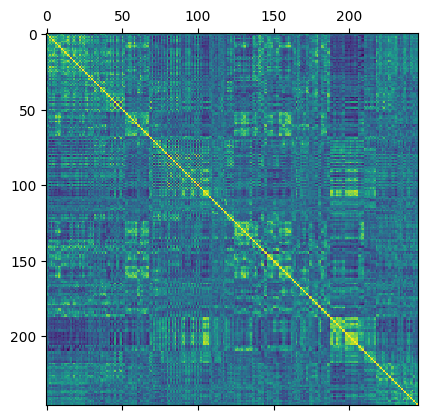

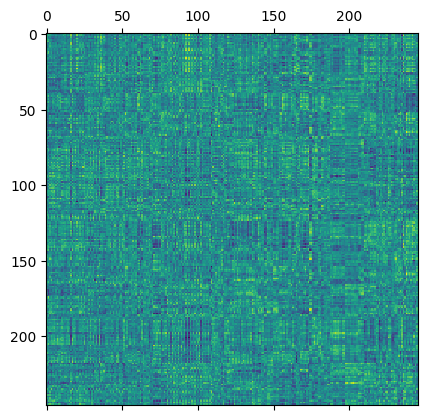

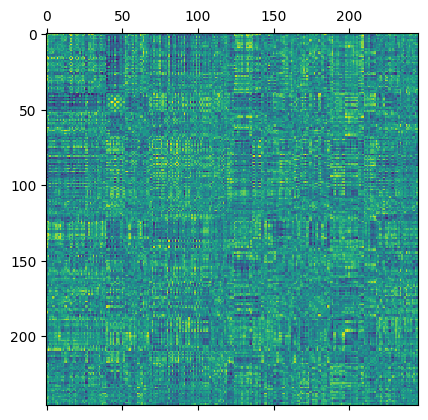

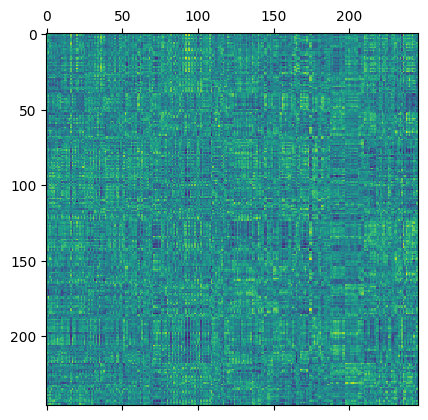

In [36]:
def vect_dist(v1, v2):
    return -scipy.spatial.distance.cosine(v1, v2)


def matr_dist(left, right):
    res = [[vect_dist(left[i], right[j]) for j in range(len(right))] for i in range(len(left))]
    return np.array(res)


guys = df.loc['Brainnetome', 'rmet', 'open', '2',   'GSR'].item()
fguys = df.loc['Brainnetome', 'rmet', 'close', '2',   'GSR'].item()
plt.matshow(matr_dist(guys[0].T, guys[0].T))
plt.show()
plt.matshow(matr_dist(fguys[0].T, fguys[0].T))
plt.show()
plt.matshow(matr_dist(guys[0].T, fguys[0].T))
plt.show()
fuck = matr_dist(guys[0].T, guys[0].T) - matr_dist(fguys[0].T, fguys[0].T)
plt.matshow(matr_dist(guys[0].T, guys[0].T) - matr_dist(fguys[0].T, fguys[0].T))
plt.show()
fuck = matr_dist(guys[0].T, fguys[0].T)
fuck = fuck + 1.0
fuck[0][0] = matr_dist(guys[0].T, guys[0].T)[0][0]
plt.matshow(fuck)
plt.show()